In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white", context="talk")

%matplotlib inline

In [105]:
FILE_LINK_AM = "../Inputs/Link_AM.csv"
FILE_LINK_PM = "../Inputs/Link_PM.csv"
FILE_TRAVEL_TIME_AM = "../Inputs/Link_Travel_Time_AM.csv"
FILE_TRAVEL_TIME_PM = "../Inputs/Link_Travel_Time_PM.csv"

In [152]:
# Analysis parameters
AM_LENGTH_SIM = 9
PM_LENGTH_SIM = 9
AM_LENGTH = 3
PM_LENGTH = 4
CONGESTION_TTR = 1.5

In [106]:
df_link_am = pd.read_csv(FILE_LINK_AM, index_col=False)
df_link_pm = pd.read_csv(FILE_LINK_PM, index_col=False)
df_tt_am = pd.read_csv(FILE_TRAVEL_TIME_AM, index_col=False)
df_tt_pm = pd.read_csv(FILE_TRAVEL_TIME_PM, index_col=False)

In [107]:
df_link_am.columns

Index(['A_NODE(f0)', 'B_NODE(f0)', 'DISTANCE(f2)', '#STREET(c20)',
       '#LENGTH(f0)', '#LTYPE(f0)', '#L_NODE(f0)', '#T_NODE(f0)',
       '#R_NODE(f0)', '#O1_NODE(f0)', '#O2_NODE(f0)', '#LANES(f0)',
       '#LBAYS(f0)', '#RBAYS(f0)', '#UTURN(f0)', '#SPEED(f0)', '#SPEEDADJ(f0)',
       '#SERFLOW(f0)', '#SATFLOW(f0)', '#GRADE(f0)', '#TFMODEL(f0)',
       '#GZONE1(f2)', '#GZONE2(f2)', '#GZONE3(f2)', '#GZONE4(f2)',
       '#GZONE5(f2)', '#STOP(f0)', '#TOLL(f2)', '#INCIDENT(f2)', '#WZONE(f2)',
       '#RMETER(f0)', '#VMS(f0)', '#HOT(f0)', '#VOLUME(f0)', '#TIME(f0)',
       '#DELAY(f2)'],
      dtype='object')

In [108]:
# Number of records; The travel time files do not contain centroid connectors, which were coded in the network
df_link_am.shape[0], df_tt_am.shape[0]

(45840, 26034)

In [109]:
link_useful_col = [
    
    'A_NODE(f0)', 'B_NODE(f0)', '#STREET(c20)', 
    'DISTANCE(f2)', '#LENGTH(f0)', '#LANES(f0)', '#SPEED(f0)', 
    '#SATFLOW(f0)', '#VOLUME(f0)', '#TIME(f0)', '#DELAY(f2)'
    
]

In [110]:
df_link_am = df_link_am.loc[:,link_useful_col]
df_link_pm = df_link_pm.loc[:,['A_NODE(f0)','B_NODE(f0)','#VOLUME(f0)', '#TIME(f0)', '#DELAY(f2)' ]]

In [111]:
# Join the columns '#VOLUME(f0)', '#TIME(f0)', '#DELAY(f2)' to AM
df_link_perf = pd.merge(df_link_am, df_link_pm, how='left', 
                        left_on=['A_NODE(f0)', 'B_NODE(f0)'], right_on=['A_NODE(f0)', 'B_NODE(f0)'],
                        suffixes=('_AM', '_PM')
                       )

In [112]:
df_link_perf.describe()

,A_NODE(f0),B_NODE(f0),DISTANCE(f2),#LENGTH(f0),#LANES(f0),#SPEED(f0),#SATFLOW(f0),#VOLUME(f0)_AM,#TIME(f0)_AM,#DELAY(f2)_AM,#VOLUME(f0)_PM,#TIME(f0)_PM,#DELAY(f2)_PM
count,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000,45840.000000
mean,8833.918150,8836.576920,0.372398,1966.259988,1.571313,29.343652,1817.131326,2999.498320,0.386941,0.028950,3689.767321,0.416538,0.039572
std,5083.670424,5083.683648,0.331871,1752.278575,0.956285,12.922723,80.984794,6386.859852,0.574983,0.269328,7445.033044,0.620497,0.288448
min,1.000000,1.000000,0.006978,36.844410,0.000000,0.000000,1800.000000,0.000000,0.000000,-0.539182,0.000000,-0.040149,-0.626904
25%,4872.000000,4873.000000,0.159883,844.179600,1.000000,20.000000,1800.000000,38.750000,0.000000,-0.010607,50.000000,0.000000,-0.011693
50%,9002.500000,8995.000000,0.298320,1575.129600,1.000000,32.000000,1800.000000,1031.500000,0.206807,0.000000,1337.000000,0.214655,0.000000
75%,13285.250000,13288.000000,0.490740,2591.107200,2.000000,36.000000,1800.000000,3299.000000,0.613606,0.000000,4229.000000,0.646520,0.000000
max,17497.000000,17497.000000,5.274370,27848.673600,7.000000,65.000000,2200.000000,74685.000000,22.405707,21.790951,82406.000000,17.701111,12.436894


In [113]:
# Clean up the link travel time data
df_tt_am = df_tt_am.iloc[:, :-1]  
df_tt_am = pd.melt(df_tt_am, id_vars=["Link","Anode","Bnode","Dist","Lanes"], var_name="Period", value_name="Travel_Time")

df_tt_pm = df_tt_pm.iloc[:, :-1]  
df_tt_pm = pd.melt(df_tt_pm, id_vars=["Link","Anode","Bnode","Dist","Lanes"], var_name="Period", value_name="Travel_Time")

In [140]:
# Remove the links not in the travel time data. They were not used in the Dynus-T model
df_tt_am = df_tt_am.set_index(["Anode","Bnode"])
df_tt_pm = df_tt_pm.set_index(["Anode","Bnode"])
df_link_perf = df_link_perf.set_index(['A_NODE(f0)', 'B_NODE(f0)'])
df_link_perf = df_link_perf.loc[df_link_perf.index.isin(df_tt_am.index),df_link_perf.columns]

### KPI-1 Travel time index during peak periods

In [115]:
# Compute FF_Time based on link attributes: #LENGTH(f0) and #SPEED(f0), Assume a minimum speed of 25 mph 
df_link_perf.loc[:,'FF_Time'] = np.where(df_link_perf.loc[:,'#SPEED(f0)']>0, 
                                           df_link_perf.loc[:,'DISTANCE(f2)'] / df_link_perf.loc[:,'#SPEED(f0)'] * 60,
                                                df_link_perf.loc[:,'DISTANCE(f2)'] / 25 * 60                                  
                                           ) 

In [123]:
# Clip the delay to zero and travel times to Free-flow travel times
df_link_perf.loc[:,'#DELAY(f2)_AM'] = np.clip(df_link_perf.loc[:,'#DELAY(f2)_AM'].values, 0, None)
df_link_perf.loc[:,'#DELAY(f2)_PM'] = np.clip(df_link_perf.loc[:,'#DELAY(f2)_PM'].values, 0, None)

df_link_perf.loc[:,'#TIME(f0)_AM'] = np.clip(df_link_perf.loc[:,'#TIME(f0)_AM'].values, df_link_perf.loc[:,'FF_Time'].values, None)
df_link_perf.loc[:,'#TIME(f0)_PM'] = np.clip(df_link_perf.loc[:,'#TIME(f0)_PM'].values, df_link_perf.loc[:,'FF_Time'].values, None)


In [124]:
df_link_perf.loc[:,['#TIME(f0)_AM','#TIME(f0)_AM', 'FF_Time']].describe()

,#TIME(f0)_AM,#TIME(f0)_AM,FF_Time
count,26034.000000,26034.000000,26034.000000
mean,0.723366,0.723366,0.557477
std,0.636966,0.636966,0.443660
min,0.039523,0.039523,0.011760
25%,0.352157,0.352157,0.260634
50%,0.584570,0.584570,0.452183
75%,0.921142,0.921142,0.728967
max,22.405707,22.405707,7.032493


In [126]:
df_link_perf.loc[:,'AM_TTR'] = df_link_perf.loc[:,'#TIME(f0)_AM'] / df_link_perf.loc[:,'FF_Time']
df_link_perf.loc[:,'PM_TTR'] = df_link_perf.loc[:,'#TIME(f0)_PM'] / df_link_perf.loc[:,'FF_Time']

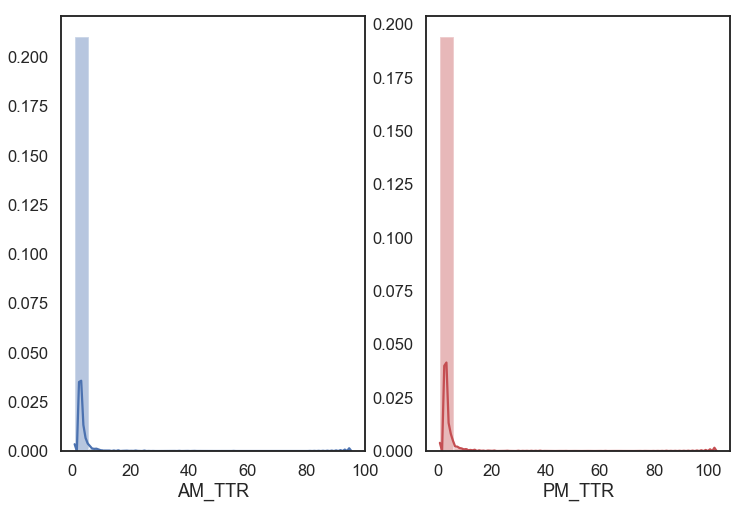

In [127]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
sns.distplot(df_link_perf.AM_TTR, bins=20, color='b', ax=ax[0]);
sns.distplot(df_link_perf.PM_TTR, bins=20, color='r', ax=ax[1]);

In [130]:
df_link_perf.loc[:, ['AM_TTR','PM_TTR']].describe()

,AM_TTR,PM_TTR
count,26034.000000,26034.000000
mean,1.465310,1.588402
std,1.452681,1.884755
min,1.000000,1.000000
25%,1.032376,1.052239
50%,1.185170,1.231651
75%,1.437127,1.554988
max,95.375752,102.944419


### KPI-2 Failing LOS Index
Based on V/C ratio computed as: Total Volume / (Service_Rate x Lanes x Period_Length)

In [132]:
df_link_perf.loc[:,'AM_VC'] = df_link_perf.loc[:,'#VOLUME(f0)_AM'] / (df_link_perf.loc[:,'#SATFLOW(f0)'] * df_link_perf.loc[:,'#LANES(f0)'] * AM_LENGTH_SIM)
df_link_perf.loc[:,'PM_VC'] = df_link_perf.loc[:,'#VOLUME(f0)_PM'] / (df_link_perf.loc[:,'#SATFLOW(f0)'] * df_link_perf.loc[:,'#LANES(f0)'] * PM_LENGTH_SIM)

(0, 6)

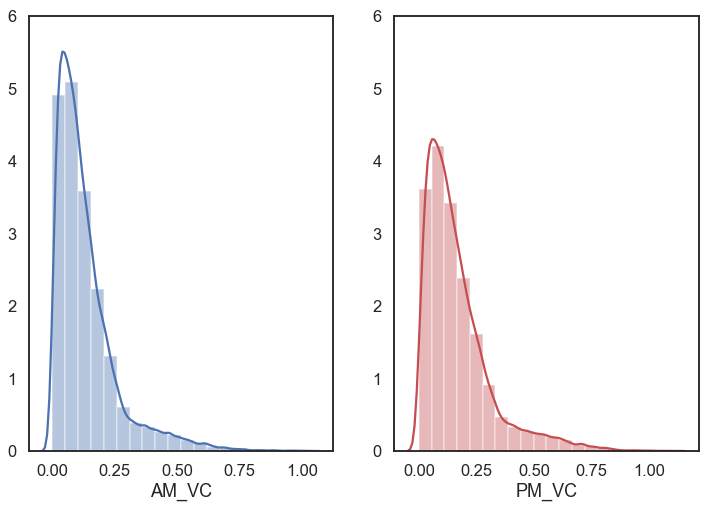

In [135]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
sns.distplot(df_link_perf.AM_VC, bins=20, color='b', ax=ax[0]);
sns.distplot(df_link_perf.PM_VC, bins=20, color='r', ax=ax[1]);
ax[0].set_ylim((0,6))
ax[1].set_ylim((0,6))

In [136]:
df_link_perf.loc[:, ['AM_VC','PM_VC']].describe()

,AM_VC,PM_VC
count,26034.000000,26034.000000
mean,0.134078,0.166789
std,0.124565,0.144851
min,0.000000,0.000000
25%,0.050943,0.066883
50%,0.099506,0.128148
75%,0.173063,0.218951
max,1.032531,1.108025


### KPI-3: Peak Congestion Index

In [137]:
# Overall maximum VC
df_link_perf.loc[:,'PEAK_VC'] = df_link_perf.loc[:,['AM_VC','PM_VC']].max(axis=1)

In [138]:
df_link_perf.loc[:, ['AM_VC','PM_VC', 'PEAK_VC']].describe()

,AM_VC,PM_VC,PEAK_VC
count,26034.000000,26034.000000,26034.000000
mean,0.134078,0.166789,0.166885
std,0.124565,0.144851,0.145083
min,0.000000,0.000000,0.000000
25%,0.050943,0.066883,0.066883
50%,0.099506,0.128148,0.128148
75%,0.173063,0.218951,0.218988
max,1.032531,1.108025,1.108025


In [168]:
def get_los(vc):
    if vc >= 0.0 and vc <= 0.4:
        return 'A'
    elif vc > 0.4 and vc <= 0.6:
        return 'B'
    elif vc > 0.6 and vc <= 0.8:
        return 'C'
    elif vc > 0.8 and vc <= 0.9:
        return 'D'
    elif vc > 1.0 and vc <= 1.1:
        return 'E'
    else:
        return 'F'

In [169]:
df_link_perf.loc[:,'LOS'] = df_link_perf.loc[:,'PEAK_VC'].apply(get_los)

In [171]:
df_link_perf.LOS.value_counts().sort_index()

A    24084
B     1340
C      510
D       71
E        6
F       23
Name: LOS, dtype: int64

### KPI-4 Congestion Duration

In [146]:
# join the speed from link data
link_fft = df_link_perf.loc[:,['FF_Time']]
link_fft.index.levels[0].name = "Anode"
link_fft.index.levels[1].name = "Bnode"
link_fft.head()

,,FF_Time
Anode,Bnode,
9683,3417,0.592717
9929,3418,2.405904
9931,3419,5.014640
10238,3420,1.496800
9837,3421,1.425636


In [147]:
df_tt_am = pd.merge(left=df_tt_am, right=link_fft, how='left', left_index=True, right_index=True).reset_index()
df_tt_pm = pd.merge(left=df_tt_pm, right=link_fft, how='left', left_index=True, right_index=True).reset_index()

In [150]:
df_tt_am.head()

,Anode,Bnode,Link,Dist,Lanes,Period,Travel_Time,FF_Time
0,3417,9364,9116,0.304,1,1,0.46,0.357765
1,3417,9364,9116,0.304,1,2,0.46,0.357765
2,3417,9364,9116,0.304,1,3,0.46,0.357765
3,3417,9364,9116,0.304,1,4,0.46,0.357765
4,3417,9364,9116,0.304,1,5,0.46,0.357765


In [151]:
df_tt_am['TTR'] = df_tt_am['Travel_Time'] / df_tt_am['FF_Time']
df_tt_pm['TTR'] = df_tt_pm['Travel_Time'] / df_tt_pm['FF_Time']
df_tt_am.head()

,Anode,Bnode,Link,Dist,Lanes,Period,Travel_Time,FF_Time,TTR
0,3417,9364,9116,0.304,1,1,0.46,0.357765,1.285761
1,3417,9364,9116,0.304,1,2,0.46,0.357765,1.285761
2,3417,9364,9116,0.304,1,3,0.46,0.357765,1.285761
3,3417,9364,9116,0.304,1,4,0.46,0.357765,1.285761
4,3417,9364,9116,0.304,1,5,0.46,0.357765,1.285761


In [153]:
def count_congested_periods(df, threshold, column='TTR'):
    return np.sum(df.loc[:,column] > threshold)

In [157]:
# df_cong_dur_am = df_tt_am.groupby(["Anode", "Bnode"]).apply(count_congested_periods, 1.5).reset_index()
# df_cong_dur_am =df_cong_dur_am.rename(columns={0:'Count_AM'})

df_cong_dur_pm = df_tt_pm.groupby(["Anode", "Bnode"]).apply(count_congested_periods, 1.5).reset_index()
df_cong_dur_pm =df_cong_dur_pm.rename(columns={0:'Count_PM'})

In [158]:
df_cong_dur = pd.merge(df_cong_dur_am, df_cong_dur_pm, how='left', left_on=["Anode", "Bnode"], right_on=["Anode", "Bnode"])

In [163]:
df_cong_dur.loc[:,'Count'] = (df_cong_dur.Count_AM / AM_LENGTH_SIM * AM_LENGTH + df_cong_dur.Count_PM / PM_LENGTH_SIM * PM_LENGTH)/ (AM_LENGTH+PM_LENGTH) 

In [164]:
df_cong_dur.describe()

,Anode,Bnode,Count_AM,Count_PM,Count
count,26034.000000,26034.000000,26034.000000,26034.000000,26034.000000
mean,10686.158716,10690.840209,1.744603,2.304832,0.229415
std,3703.591514,3701.280079,2.909926,3.287892,0.341631
min,3417.000000,3417.000000,0.000000,0.000000,0.000000
25%,7265.000000,7284.250000,0.000000,0.000000,0.000000
50%,10695.000000,10705.500000,0.000000,0.000000,0.000000
75%,13662.750000,13668.000000,3.000000,5.000000,0.428571
max,17497.000000,17497.000000,9.000000,9.000000,1.000000


### Write the outputs

In [173]:
df_link_perf.to_csv('../Outputs/link_performance.csv', index=False)
df_cong_dur.to_csv('../Outputs/congestion_duration.csv', index=False)